In [1]:
from APP_Constants import APP_constants as CN
from APP_logger.app_logger import APP_Logger
from APP_utils.common_utils import download_file , reduce_memory_usage , get_latest_file , profile_report_
from APP_Database_operations.mongodb_operations import MongoDB
import logging as lg 
import os

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
lg = APP_Logger("Data_load")

In [4]:
lg.info('Data Injection Started')

Data Injection Started


In [ ]:
def data_injection(PREPROCESSING_DATA_FILENAME="PREPROCESSING_DATA.csv", 
                    TRAIN_DATA_FILENAME="TRAIN_DATA.csv",
                    TEST_DATA_FILENAME="TEST_DATA.csv",
                    MONGO_DB =CN.MONGO_DB_NAME , 
                    PREPROCESSING_COLLECTION = CN.MONGO_PREPROCESSING_COLLECTION,
                    TRAIN_COLLECTION= CN.MONGO_TRAIN_COLLECTION , 
                    TEST_COLLECTION = CN.MONGO_TEST_COLLECTION ,
                    RAW_DATA_URL = CN.RAW_DATA_URL , 
                    RAW_DATA_DIR = CN.RAW_DATA_DIR ,
                    PREPROCESSING_DATA_DIR=CN.PREPROCESSING_DATA_DIR ,
                    TRAIN_DATA_DIR=CN.TRAIN_DATA_DIR ,
                    TEST_DATA_DIR=CN.TEST_DATA_DIR ,
                    ):



    """ This function is used to inject the data into the database  """


    # initial the mongodb object
    Conn_obj_preprocessing = MongoDB( MONGO_DB , PREPROCESSING_COLLECTION)
    Conn_obj_preprocessing.drop_collection(PREPROCESSING_COLLECTION)
    Conn_obj_Train = MongoDB( MONGO_DB , TRAIN_COLLECTION)
    Conn_obj_Train.drop_collection(TRAIN_COLLECTION)
    Conn_obj_Test = MongoDB( MONGO_DB , TEST_COLLECTION)
    Conn_obj_Test.drop_collection(TEST_COLLECTION)
    
   #######################################################################################################################################
    lg.info("Data Injection Started")
    lg.info("Downloading the data")
    File_path = download_file(RAW_DATA_URL)

    if File_path is None:
        lg.error("Downloading the data failed")
        return None
    lg.info("Data downloaded successfully")
   
    lg.info("Reading the data")
    raw_data_file = get_latest_file(RAW_DATA_DIR) # get the latest file from the directory
    lg.info("Raw data file is : {}".format(raw_data_file))
    # skip header as per the data 
    df = pd.read_csv(raw_data_file , header=1 )
    lg.info("Dataframe created successfully")
    lg.info("as there is same empty space in column name we will strip it")
    
    df.columns = [columns.strip() for columns  in df.columns.to_list() ] # strip the column name of space 
    lg.info("Columns names are : {}".format(df.columns.to_list()))

    lg.debug("Data to drop column No : 122 as its the area name : {}".format(df.iloc[122].to_dict()))
    df.drop(df.index[122], inplace=True) # drop the row 122 as its the area name
    
    lg.info("Data dropped successfully")
    lg.info('Dropping the column name in Sidi-Bel Abbes Region Dataset')
    df.drop(df[df["day"] == "day"].index , axis = 0 , inplace = True)
    # change dat types in the dataframe
    lg.info("Data type changed for column :  day {} to int32".format(df["day"].dtype))
    df.day = df.day.astype('int32')
    lg.info("Data type changed for column :  month {} to int32".format(df["month"].dtype))
    df.month = df.month.astype('int32')
    lg.info("Data type changed for column :  year {} to int32".format(df["year"].dtype))
    df.year = df.year.astype('int32')
    lg.info("Data type changed for column : Temperature  {} to int32".format(df["Temperature"].dtype))
    df.Temperature =  df.Temperature.astype('float32')
    lg.info("Data type changed for column :  RH {} to int32".format(df["RH"].dtype))
    df.RH= df.RH.astype('float32')
    lg.info("Data type changed for column :  Wind_speed {} to int32".format(df["Ws"].dtype))
    df.Ws= df.Ws.astype('float32')
    lg.info("Data type changed for column :  Rain {} to int32".format(df["Rain"].dtype))
    df['Rain']=df['Rain'].astype('float32')
    lg.info("Data type changed for column :  FFMC {} to int32".format(df["FFMC"].dtype))
    df['FFMC']=df['FFMC'].astype('float32')
    lg.info("Data type changed for column :  DMC {} to int32".format(df["DMC"].dtype))
    df['DMC']=df['DMC'].astype('float32')
    lg.info("Data type changed for column :  DC {} to int32 as there is a empty space in the value we replace".format(df["DC"].dtype))
    df['DC'] = df['DC'].apply(lambda x: x.replace(' ','')).astype('float32')
    lg.info("Data type changed for column :  ISI {} to int32".format(df["ISI"].dtype))
    df['ISI']= df['ISI'].astype('float32')
    lg.info("Data type changed for column :  BUI {} to int32".format(df["BUI"].dtype))
    df['BUI']= df['BUI'].astype('float32')
    lg.info("Data type changed for column :  FWI {} to int32".format(df["FWI"].dtype))
    lg.info("for fire columns we have a value which is fire so we will replace it with Nan{}" . format(df[df['FWI']=='fire   ']['FWI']))
    df['FWI']=df['FWI'].apply(lambda x: x.replace('fire   ','NaN')).astype('float32')
    df['Classes'].fillna('Fire', inplace=True)
    lg.info("Lets split the data into different  region and create a two data frame and add the region indicator")
    
    Data_Region = df.iloc[1:122 , :].copy()
    Data_Region1 = df.iloc[122: , :].copy()

    raw_data_file = get_latest_file(CN.RAW_DATA_DIR)
    Data_Region_Dummy = pd.read_csv(raw_data_file )
    Region1 = Data_Region_Dummy.columns.to_list()[0].strip()
    lg.info("Region1 is : {}".format(Region1))
    Data_Region_Dummy1 =  pd.read_csv(raw_data_file , header=1 )
    Region2 = Data_Region_Dummy1.iloc[122]['day']
    lg.info("Region2 is : {}".format(Region2))
    #######################################################################################################################################
    Data_Region["forest"] = Region1
    Data_Region1["forest"] = Region2
    ########################################################################################################################################
    final_df = Data_Region.append(Data_Region1)
    filename = os.path.join(PREPROCESSING_DATA_DIR, PREPROCESSING_DATA_FILENAME)
    lg.info("Saving the data to the file : {}".format(filename))
    final_df.to_csv(filename )
    lg.info("Data Injection Completed")
    dB_data = final_df.to_dict(orient='records')
    Conn_obj_preprocessing.insert_many__(dB_data)
    lg.info(f"Data Injected successfully into the database {CN.MONGO_DB_NAME} , collection {CN.MONGO_PREPROCESSING_COLLECTION}")
    #######################################################################################################################################
    
    df_to_split = reduce_memory_usage(final_df)
    lg.info("Dataframe reduced successfully")
    lg.info("Data farme has 2 null values in the same line , the Reason is because the value was entered in the ")
    lg.info("Dataframe shape is : {}".format(df_to_split.shape))
    lg.info('We will standardize the  classes as "No Fire" if not in x.lower() else "Fire"')
    df_to_split['Classes'] = df_to_split['Classes'].apply(lambda x: "No Fire" if 'not' in x.lower() else "Fire")
    #Splitting data into train and test
    df_to_split.reset_index(drop=True , inplace=True)
    strata_train_set = None
    strata_test_set = None
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    for train_index, test_index in split.split(df_to_split, df_to_split['Classes']):
        strata_train_set = df_to_split.loc[train_index]
        strata_test_set = df_to_split.loc[test_index]
    lg.info("Data splitted successfully")
    lg.info("Train set shape is : {}".format(strata_train_set.shape))
    lg.info("Test set shape is : {}".format(strata_test_set.shape))
    
    strata_test_set.to_csv(os.path.join(TEST_DATA_DIR, TEST_DATA_FILENAME))
    lg.info("Test data saved successfully")
    strata_train_set.to_csv(os.path.join(TRAIN_DATA_DIR, TRAIN_DATA_FILENAME))
    lg.info("Train data saved successfully")

    test_data = strata_test_set.to_dict(orient='records')
    train_data = strata_train_set.to_dict(orient='records')
    Conn_obj_Train.insert_many__(train_data)
    Conn_obj_Test.insert_many__(test_data)
    lg.info(f"Data Injected successfully into the database {MONGO_DB} , collection {TRAIN_COLLECTION}")
    lg.info(f"Data Injected successfully into the database {MONGO_DB} , collection {TEST_COLLECTION}")
    
    return True

In [6]:
download_file(CN.RAW_DATA_URL)

'/home/pk/Desktop/Eda/Algerian_forest_fires_dataset/Artifacts/2022-05-28/RAW_DATA/Algerian_forest_fires_dataset_UPDATE.csv'

In [7]:
raw_data_file = get_latest_file(CN.RAW_DATA_DIR)

In [8]:
df = pd.read_csv(raw_data_file  )

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 247 entries, ('day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI') to ('30', '09', '2012', '24', '64', '15', '0.2', '67.3', '3.8', '16.5', '1.2', '4.8', '0.5')
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Bejaia Region Dataset   245 non-null    object
dtypes: object(1)
memory usage: 49.3+ KB


In [11]:
df.columns

Index(['Bejaia Region Dataset '], dtype='object')

In [24]:
df.iloc[123 ,]

Bejaia Region Dataset     NaN
Name: (Sidi-Bel Abbes Region Dataset, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan), dtype: object

In [9]:
lg.info(f"There is space in the class columns we strip the column name and the space {df.columns.to_list()}")

There is space in the class columns we strip the column name and the space ['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  ']


In [10]:
df.columns = [columns.strip() for columns  in df.columns.to_list() ]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   day          246 non-null    object
 1   month        245 non-null    object
 2   year         245 non-null    object
 3   Temperature  245 non-null    object
 4   RH           245 non-null    object
 5   Ws           245 non-null    object
 6   Rain         245 non-null    object
 7   FFMC         245 non-null    object
 8   DMC          245 non-null    object
 9   DC           245 non-null    object
 10  ISI          245 non-null    object
 11  BUI          245 non-null    object
 12  FWI          245 non-null    object
 13  Classes      244 non-null    object
dtypes: object(14)
memory usage: 27.0+ KB


In [12]:
lg.info("Lets analyze the dataframe dtypes")

Lets analyze the dataframe


In [15]:
for feature in df.columns.tolist(): display(f'feature : {feature} , unique values: {len(df[feature].unique())} , dtypes: {df[feature].dtype}')

'feature : day , unique values: 33 , dtypes: object'

'feature : month , unique values: 6 , dtypes: object'

'feature : year , unique values: 3 , dtypes: object'

'feature : Temperature , unique values: 21 , dtypes: object'

'feature : RH , unique values: 64 , dtypes: object'

'feature : Ws , unique values: 20 , dtypes: object'

'feature : Rain , unique values: 41 , dtypes: object'

'feature : FFMC , unique values: 175 , dtypes: object'

'feature : DMC , unique values: 168 , dtypes: object'

'feature : DC , unique values: 200 , dtypes: object'

'feature : ISI , unique values: 108 , dtypes: object'

'feature : BUI , unique values: 176 , dtypes: object'

'feature : FWI , unique values: 129 , dtypes: object'

'feature : Classes , unique values: 10 , dtypes: object'

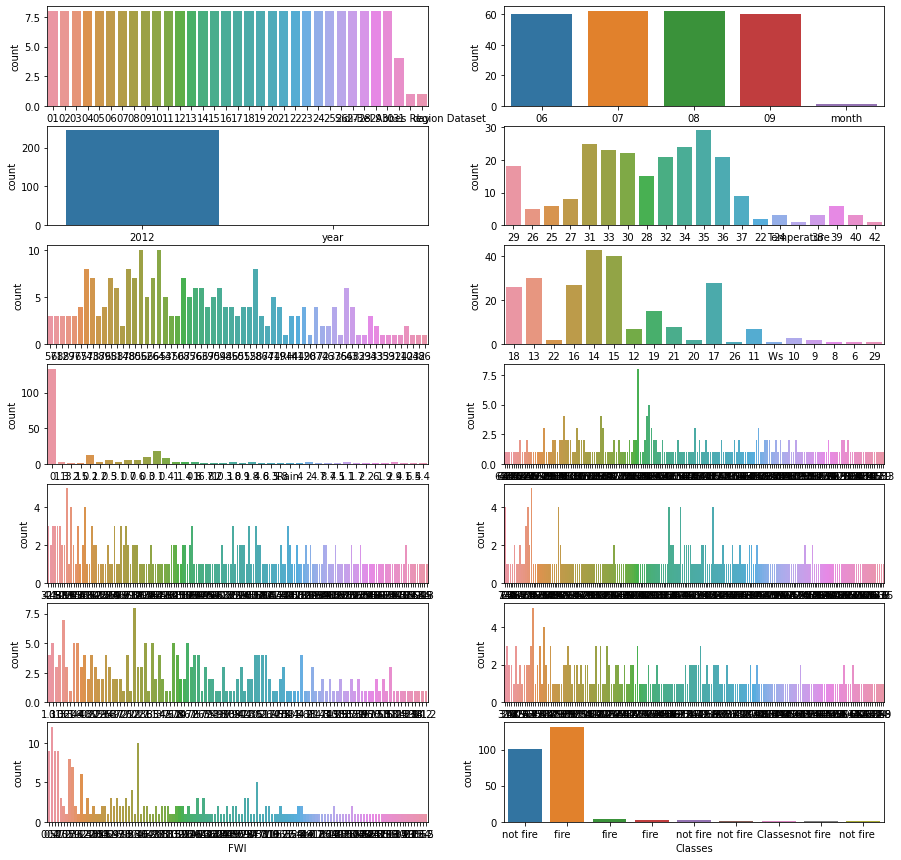

In [27]:
fig , axis = plt.subplots(7,2,figsize=(15,15))
for ax , feature in zip(axis.flatten(), df.columns.tolist()): sns.countplot(x=feature, data=df , ax = ax)

In [54]:
df.iloc[:60 ,:-1]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
0,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5
1,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4
2,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1
3,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0
4,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5
5,06,06,2012,31,67,14,0,82.6,5.8,22.2,3.1,7,2.5
6,07,06,2012,33,54,13,0,88.2,9.9,30.5,6.4,10.9,7.2
7,08,06,2012,30,73,15,0,86.6,12.1,38.3,5.6,13.5,7.1
8,09,06,2012,25,88,13,0.2,52.9,7.9,38.8,0.4,10.5,0.3
9,10,06,2012,28,79,12,0,73.2,9.5,46.3,1.3,12.6,0.9


In [55]:
df.iloc[60:120 ,:-1]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
60,31,07,2012,35,64,17,0,87.2,31.9,145.7,6.8,41.2,15.7
61,01,08,2012,36,45,14,0,78.8,4.8,10.2,2,4.7,0.9
62,02,08,2012,35,55,12,0.4,78,5.8,10,1.7,5.5,0.8
63,03,08,2012,35,63,14,0.3,76.6,5.7,10,1.7,5.5,0.8
64,04,08,2012,34,69,13,0,85,8.2,19.8,4,8.2,3.9
65,05,08,2012,34,65,13,0,86.8,11.1,29.7,5.2,11.5,6.1
66,06,08,2012,32,75,14,0,86.4,13,39.1,5.2,14.2,6.8
67,07,08,2012,32,69,16,0,86.5,15.5,48.6,5.5,17.2,8
68,08,08,2012,32,60,18,0.3,77.1,11.3,47,2.2,14.1,2.6
69,09,08,2012,35,59,17,0,87.4,14.8,57,6.9,17.9,9.9


In [56]:
df.iloc[120:160 ,:-1]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
120,29,09,2012,26,80,16,1.8,47.4,2.9,7.7,0.3,3,0.1
121,30,09,2012,25,78,14,1.4,45,1.9,7.5,0.2,2.4,0.1
122,Sidi-Bel Abbes Region Dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
124,01,06,2012,32,71,12,0.7,57.1,2.5,8.2,0.6,2.8,0.2
125,02,06,2012,30,73,13,4,55.7,2.7,7.8,0.6,2.9,0.2
126,03,06,2012,29,80,14,2,48.7,2.2,7.6,0.3,2.6,0.1
127,04,06,2012,30,64,14,0,79.4,5.2,15.4,2.2,5.6,1
128,05,06,2012,32,60,14,0.2,77.1,6,17.6,1.8,6.5,0.9
129,06,06,2012,35,54,11,0.1,83.7,8.4,26.3,3.1,9.3,3.1


In [57]:
df.isna().sum()

day            0
month          1
year           1
Temperature    1
RH             1
Ws             1
Rain           1
FFMC           1
DMC            1
DC             1
ISI            1
BUI            1
FWI            1
Classes        2
dtype: int64

In [58]:
df[df["Classes"].isnull()]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
122,Sidi-Bel Abbes Region Dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,14,07,2012,37,37,18,0.2,88.9,12.9,14.6 9,12.5,10.4,fire,NaN


In [61]:
df.drop(122 , axis = 0 , inplace = True)

In [62]:
df[df["Classes"].isnull()]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
167,14,07,2012,37,37,18,0.2,88.9,12.9,14.6 9,12.5,10.4,fire,NaN


In [76]:
df[df["day"] == "day"]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
123,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes


In [77]:
df["day"].value_counts()

01     8
02     8
30     8
29     8
28     8
27     8
26     8
25     8
24     8
23     8
22     8
21     8
20     8
19     8
18     8
17     8
16     8
15     8
14     8
13     8
12     8
11     8
10     8
09     8
08     8
07     8
06     8
05     8
04     8
03     8
31     4
day    1
Name: day, dtype: int64

<AxesSubplot:>

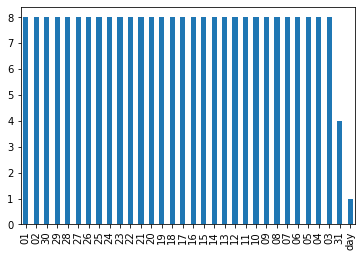

In [78]:
df["day"].value_counts().plot(kind='bar')

In [81]:
df.drop(df[df["day"] == "day"].index , axis = 0 , inplace = True)

In [83]:
columns = df.columns.tolist()

<AxesSubplot:>

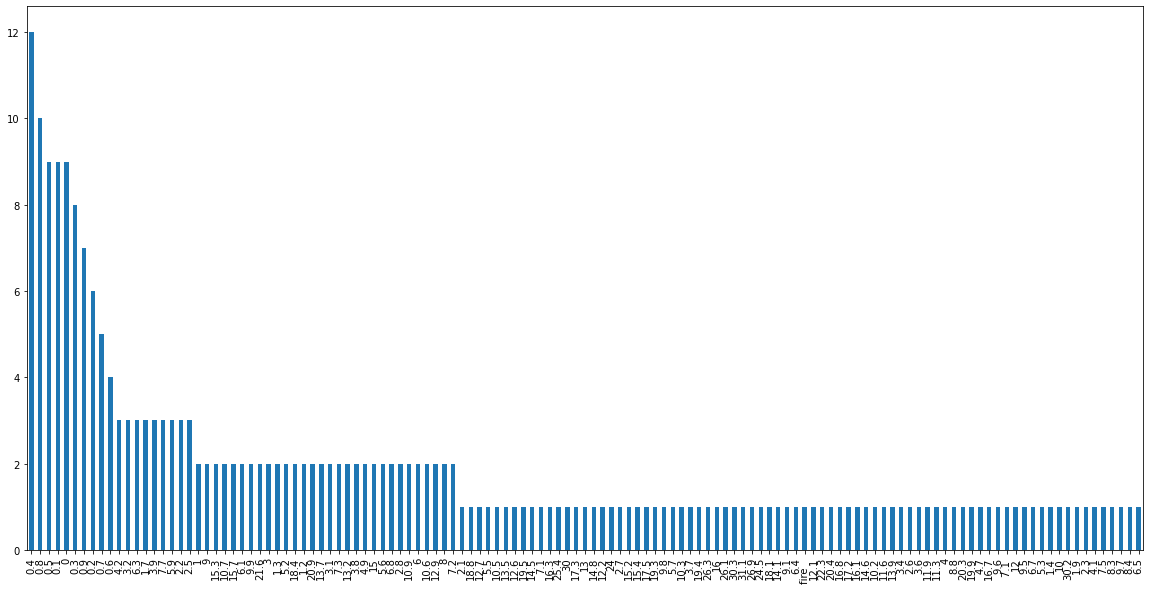

In [91]:
plt.figure(figsize=(20,10))
df['FWI'].value_counts().plot(kind='bar')

In [92]:
df.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
2,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
4,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire


In [96]:
df.day.astype('int32')

0       1
1       2
2       3
3       4
4       5
       ..
241    26
242    27
243    28
244    29
245    30
Name: day, Length: 244, dtype: int32

In [97]:
df.month.astype('int32')

0      6
1      6
2      6
3      6
4      6
      ..
241    9
242    9
243    9
244    9
245    9
Name: month, Length: 244, dtype: int32

In [98]:
df.year.astype('int32')

0      2012
1      2012
2      2012
3      2012
4      2012
       ... 
241    2012
242    2012
243    2012
244    2012
245    2012
Name: year, Length: 244, dtype: int32

In [99]:
df.Temperature.astype('float32')

0      29.0
1      29.0
2      26.0
3      25.0
4      27.0
       ... 
241    30.0
242    28.0
243    27.0
244    24.0
245    24.0
Name: Temperature, Length: 244, dtype: float32

In [101]:
df.RH.astype('float32')

0      57.0
1      61.0
2      82.0
3      89.0
4      77.0
       ... 
241    65.0
242    87.0
243    87.0
244    54.0
245    64.0
Name: RH, Length: 244, dtype: float32

In [102]:
df.Ws.astype('float32')

0      18.0
1      13.0
2      22.0
3      13.0
4      16.0
       ... 
241    14.0
242    15.0
243    29.0
244    18.0
245    15.0
Name: Ws, Length: 244, dtype: float32

In [105]:
df['Rain'].astype('float32')

0       0.0
1       1.3
2      13.1
3       2.5
4       0.0
       ... 
241     0.0
242     4.4
243     0.5
244     0.1
245     0.2
Name: Rain, Length: 244, dtype: float32

In [107]:
df['FFMC'].astype('float32')

0      65.699997
1      64.400002
2      47.099998
3      28.600000
4      64.800003
         ...    
241    85.400002
242    41.099998
243    45.900002
244    79.699997
245    67.300003
Name: FFMC, Length: 244, dtype: float32

In [110]:
df['DMC'].astype('float32')

0       3.4
1       4.1
2       2.5
3       1.3
4       3.0
       ... 
241    16.0
242     6.5
243     3.5
244     4.3
245     3.8
Name: DMC, Length: 244, dtype: float32

In [119]:
df['DC'].value_counts().sort_values(ascending=False).tail(60)

10.4      1
14.6 9    1
24.1      1
115.6     1
42.3      1
51.6      1
61.1      1
71        1
80.6      1
90.1      1
99        1
56.6      1
19.4      1
44.5      1
9.9       1
9.7       1
26.3      1
159.1     1
168.2     1
26.6      1
17.6      1
42.7      1
52.5      1
9.8       1
20.2      1
30.9      1
54.2      1
65.1      1
76.4      1
86.8      1
96.8      1
107       1
117.1     1
127.5     1
21.4      1
49.3      1
15.4      1
8.8       1
32.1      1
10.5      1
17.7      1
67.2      1
26.1      1
33.4      1
37.6      1
50.2      1
59.2      1
63.3      1
77.8      1
86        1
88        1
28.1      1
97.3      1
106.3     1
167.2     1
157.5     1
147.7     1
137.7     1
47.2      1
16.5      1
Name: DC, dtype: int64

In [121]:
df['DC'] = df['DC'].apply(lambda x: x.replace(' ','')).astype('float32')

In [122]:
df['DC'].dtype

dtype('float32')

In [125]:
df['ISI'].astype('float32')

0      1.3
1      1.0
2      0.3
3      0.0
4      1.2
      ... 
241    4.5
242    0.1
243    0.4
244    1.7
245    1.2
Name: ISI, Length: 244, dtype: float32

In [128]:
df['BUI'].astype('float32')

0       3.4
1       3.9
2       2.7
3       1.7
4       3.9
       ... 
241    16.9
242     6.2
243     3.4
244     5.1
245     4.8
Name: BUI, Length: 244, dtype: float32

In [131]:
df['FWI'].value_counts().sort_values(ascending=False).tail(60)

6.7        1
4.7        1
1.9        1
fire       1
8.4        1
9.7        1
8.3        1
7.5        1
4.1        1
2.3        1
30.2       1
16.7       1
10         1
1.4        1
5.3        1
9.5        1
12         1
7.1        1
9.6        1
12.1       1
13         1
6.4        1
14.5       1
12.2       1
14.8       1
17.3       1
30         1
25.4       1
16.3       1
7.1        1
19.5       1
2.7        1
12.6       1
13.5       1
10.5       1
5.5        1
12.7       1
18.8       1
2.1        1
24         1
15.2       1
9.1        1
16         1
14.1       1
18.1       1
24.5       1
26.9       1
31.1       1
30.3       1
26.1       1
26.3       1
15.4       1
19.4       1
3.7        1
10.3       1
5.7        1
9.8        1
19.3       1
17.5       1
6.5        1
Name: FWI, dtype: int64

In [136]:
df[df['FWI']=='fire   ']

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
167,14,07,2012,37,37,18,0.2,88.9,12.9,14.69,12.5,10.4,fire,NaN


In [137]:
df.iloc[162: 175 , :]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
164,11,07,2012,34,56,15,2.9,74.8,7.1,9.500000,1.6,6.8,0.8,not fire
165,12,07,2012,36,44,13,0,90.1,12.6,19.400000,8.3,12.5,9.6,fire
166,13,07,2012,39,45,13,0.6,85.2,11.3,10.400000,4.2,10.9,4.7,fire
167,14,07,2012,37,37,18,0.2,88.9,12.9,14.690000,12.5,10.4,fire,NaN
168,15,07,2012,34,45,17,0,90.5,18,24.100000,10.9,17.7,14.1,fire
169,16,07,2012,31,83,17,0,84.5,19.4,33.099998,4.7,19.2,7.3,fire
170,17,07,2012,32,81,17,0,84.6,21.1,42.299999,4.7,20.9,7.7,fire
171,18,07,2012,33,68,15,0,86.1,23.9,51.599998,5.2,23.9,9.1,fire
172,19,07,2012,34,58,16,0,88.1,27.8,61.099998,7.3,27.7,13,fire
173,20,07,2012,36,50,16,0,89.9,32.7,71.000000,9.5,32.6,17.3,fire


In [142]:
df['FWI'].apply(lambda x: x.replace('fire   ','NaN')).astype('float32')

0      0.5
1      0.4
2      0.1
3      0.0
4      0.5
      ... 
241    6.5
242    0.0
243    0.2
244    0.7
245    0.5
Name: FWI, Length: 244, dtype: float32

In [65]:
filename = get_latest_file(CN.PREPROCESSING_DATA_DIR)
df = pd.read_csv(filename)

In [66]:
df = pd.read_csv(filename)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   243 non-null    int64  
 1   day          243 non-null    int64  
 2   month        243 non-null    int64  
 3   year         243 non-null    int64  
 4   Temperature  243 non-null    float64
 5   RH           243 non-null    float64
 6   Ws           243 non-null    float64
 7   Rain         243 non-null    float64
 8   FFMC         243 non-null    float64
 9   DMC          243 non-null    float64
 10  DC           243 non-null    float64
 11  ISI          243 non-null    float64
 12  BUI          243 non-null    float64
 13  FWI          242 non-null    float64
 14  Classes      242 non-null    object 
 15  forest       243 non-null    object 
dtypes: float64(10), int64(4), object(2)
memory usage: 30.5+ KB


In [68]:
df = reduce_memory_usage(df)

Memory usage decreased from 0.06MB to 0.01MB (0.05MB, 79.60% reduction)


In [75]:
df[df["Classes"].isnull()]

,Unnamed: 0,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,forest
164,167,14,7,2012,37.0,37.0,18.0,0.2,88.900002,12.9,14.69,12.5,10.4,NaN,NaN,Sidi-Bel Abbes Region Dataset


In [80]:
filename = get_latest_file(CN.RAW_DATA_DIR)
df = pd.read_csv(filename , header=1 )

In [90]:
df[df['Classes  '].isnull()]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes


In [86]:
import numpy as np 

In [89]:
df['Classes  '].fillna('Fire', inplace=True)

In [95]:
filename = get_latest_file(CN.PREPROCESSING_DATA_DIR)
df = pd.read_csv(filename , index_col=0)

In [97]:
df.isnull().sum()

day            0
month          0
year           0
Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            1
Classes        0
forest         0
dtype: int64

In [100]:
df.groupby(['forest',"day"])["Temperature"].mean()

forest                         day
Bejaia Region Dataset          1      30.00
                               2      28.25
                               3      29.50
                               4      30.25
                               5      30.75
                                      ...  
Sidi-Bel Abbes Region Dataset  27     32.25
                               28     33.00
                               29     32.50
                               30     32.00
                               31     33.50
Name: Temperature, Length: 62, dtype: float64

In [102]:
sns.scatterplot(x="day", y="Temperature", data=df)

<AxesSubplot:xlabel='day', ylabel='Temperature'>